**Data Scraping**


---



In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By

import time

def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920,1200")
    options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(options=options)
    return driver



In [ ]:
import time
def scraper(url):
    driver = web_driver()

    driver.get(url)

    step = 0
    while step<150:
        driver.execute_script("window.scrollBy(0, 100000);")
        step += 1
        time.sleep(1)




    dataset = []
    review_elements = driver.find_elements(By.CLASS_NAME, "apphub_UserReviewCardContent")


    for review_element in review_elements:
    #Review Helpful Vote Count:(Review vote count):

        vote = review_element.find_element(By.CLASS_NAME, "found_helpful")
        vote = vote.text.split()
        if vote[0] == "No":
            vote = 0
        else:
            vote = vote[0]

    #Review
        review_text = review_element.find_element(By.CLASS_NAME, "apphub_CardTextContent")
        review_text = review_text.text.split()
        review_text = review_text[3:]
        review_text = ' '.join(review_text)

    #Sentiment
        review_sentiment = review_element.find_element(By.CLASS_NAME, "title")
        if review_sentiment.text == "Recommended":
            review_sentiment = 1
        else:
            review_sentiment = 0


    #Hours Played
        hours = review_element.find_element(By.CLASS_NAME, "hours")
        hours = hours.text.split()
        for hour in hours:
            hour = float(hour.replace(',', ''))
            if '.' in str(hour):
                hour = float(hour)
                break


        import csv
        structured_data = {
            "review": review_text,
            "hours": hour,
            "votes": vote,
            "sentiment": review_sentiment
        }


        csv_file_path = "steam_data.csv"


        with open(csv_file_path, mode='a', newline='') as csv_file:

            csv_writer = csv.writer(csv_file)


            if csv_file.tell() == 0:
                header = structured_data.keys()
                csv_writer.writerow(header)


            data = structured_data.values()
            csv_writer.writerow(data)
    driver.quit()
    print("New Game Data Added")

In [ ]:
games = ['730','570','578080','1172470','271590','1938090','1238810','1174180','1245620','252950']

for g in games:
    steam_review_page = f"https://steamcommunity.com/app/{g}/reviews/?browsefilter=mostrecent"
    scraper(steam_review_page)

New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added
New Game Data Added


In [ ]:
print(len(review_elements))

20


**Data Wrangling**

In [1]:
import pandas as pd
dataset = pd.read_csv('steam_data.csv')
dataset.head()


,review,hours,votes,sentiment
0,dam,130.1,0,1
1,bad game,503.2,0,0
2,Just play it !!!!!,379.4,0,1
3,deo vao dc,223.0,0,0
4,nice game yk for real try it!,16.7,0,1


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13460 entries, 0 to 13459
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     13418 non-null  object 
 1   hours      13460 non-null  float64
 2   votes      13460 non-null  int64  
 3   sentiment  13460 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 420.8+ KB


In [3]:
dataset.describe()

,hours,votes,sentiment
count,13460.000000,13460.000000,13460.000000
mean,445.780654,0.369019,0.811144
std,1064.064766,4.163160,0.391409
min,0.100000,0.000000,0.000000
25%,21.800000,0.000000,1.000000
50%,89.950000,0.000000,1.000000
75%,370.575000,0.000000,1.000000
max,23995.200000,280.000000,1.000000


checking missing values

In [4]:
missing_values = dataset.isnull().sum()
if missing_values.empty:
  print("The Dataset has no missing values")
else:
  print("The number of missing values are :",missing_values)

The number of missing values are : review       42
hours         0
votes         0
sentiment     0
dtype: int64


handling missing values

In [5]:
dataset = dataset.dropna(subset=['review'])
missing_values = dataset.isnull().sum()
if missing_values.empty:
  print("The Dataset has no missing values")
else:
  print("The number of missing values are :",missing_values)

The number of missing values are : review       0
hours        0
votes        0
sentiment    0
dtype: int64


checking for duplicate values

In [6]:
duplicates = dataset[dataset.duplicated()]
print('Number of duplicate rows :',duplicates)

Number of duplicate rows :                                             review  hours  votes  sentiment
1017                                          best   51.0      0          1
1021                            love + hate = csgo   51.0      0          1
1023                                          best   51.0      0          1
1025                                            <3   51.0      0          1
1027   Press 'E' on any chicken and it follows you   51.0      0          1
...                                            ...    ...    ...        ...
9153                                     good game   15.8      0          1
11255                                         good   11.1      0          1
11409                                         good   18.0      0          1
11694                                          yes   33.6      0          1
13168                                            .   57.4      0          1

[211 rows x 4 columns]


checking for outliers

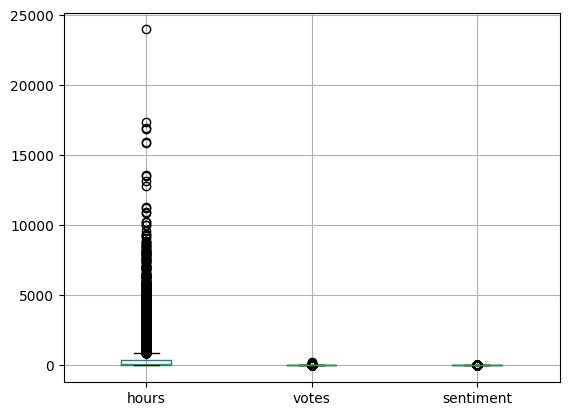

In [7]:
import matplotlib.pyplot as plt

dataset.boxplot(column=['hours', 'votes','sentiment'])
plt.show()

handling outliers

In [8]:
from scipy import stats
import numpy as np

z_scores = stats.zscore(dataset[['hours', 'votes','sentiment']])
abs_z_scores = np.abs(z_scores)

outliers = (abs_z_scores > 2).all(axis=1)
dataset = dataset[~outliers]

print(dataset)

                                                  review   hours  votes  \
0                                                    dam   130.1      0   
1                                               bad game   503.2      0   
2                                     Just play it !!!!!   379.4      0   
3                                             deo vao dc   223.0      0   
4                          nice game yk for real try it!    16.7      0   
...                                                  ...     ...    ...   
13455                                          Good game   503.4      0   
13456  Servers get worse each season and honestly it ...  4026.4      1   
13457  Fun but can be competitive. Many different ski...   709.9      0   
13458  Your first question to news like this might be...  1825.0      0   
13459  Really really liked the game and I'm playing i...   402.5      0   

       sentiment  
0              1  
1              0  
2              1  
3              0  
4   

Removing stopwords and stemming

In [9]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')


def preprocess_text(text):
    text = str(text)
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    text = re.sub(r'[^\w\s]', '', text)
    words = [ps.stem(word) for word in text.split() if word.lower() not in stop_words]
    return ' '.join(words)

dataset['review'] = dataset['review'].apply(preprocess_text)
print(dataset['review'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                                                      dam
1                                                 bad game
2                                                     play
3                                               deo vao dc
4                                    nice game yk real tri
                               ...                        
13455                                            good game
13456    server get wors season honestli renam chaser l...
13457    fun competit mani differ skill rang nice break...
13458    first question news like might mean rocket lea...
13459    realli realli like game im play time epic took...
Name: review, Length: 13418, dtype: object


In [10]:
!python -m spacy download en_core_web_lg


2023-12-07 15:50:06.701527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 15:50:06.701597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 15:50:06.701650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 15:50:06.711329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 15:50:08.656520: W tensorflow/compiler/

In [11]:
import spacy
import pandas as pd

nlp = spacy.load('en_core_web_lg')

def get_glove_embedding(text):
    doc = nlp(text)

    return doc.vector if len(doc) != 0 else None

dataset['glove_embedding'] = dataset['review'].apply(get_glove_embedding)

print("GloVe Embeddings:")
print(dataset['glove_embedding'])


GloVe Embeddings:
0        [0.80092, 1.6632, -4.3544, -3.1602, -0.33467, ...
1        [-3.15775, 1.45965, 1.0442, -2.5416, 0.737525,...
2        [-1.0754, 4.7398, 0.91211, -3.9297, -0.056025,...
3        [-0.29579666, 0.26760665, -0.7764433, -0.53602...
4        [-0.33060014, 2.864032, -1.170655, 0.926672, 0...
                               ...                        
13455    [-2.6031399, 1.7107501, 0.20235002, -0.9439, 1...
13456    [-0.049080998, 0.89648, 0.43398497, 0.5776237,...
13457    [-0.5504611, 0.73337895, -2.4228811, 0.0277622...
13458    [0.009238909, 1.3055127, -0.919962, -0.1483625...
13459    [-0.4395473, 1.1843067, -0.8842051, -0.7143814...
Name: glove_embedding, Length: 13418, dtype: object


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

sample_embedding_shape = dataset['glove_embedding'].iloc[0].shape
print("Sample GloVe Embedding Shape:", sample_embedding_shape)


max_embedding_length = max(embedding.shape[0] for embedding in dataset['glove_embedding'] if embedding is not None)

X_lstm_padded = np.array([np.pad(embedding, (0, max_embedding_length - embedding.shape[0]), mode='constant') for embedding in dataset['glove_embedding'] if embedding is not None])


X_lstm = X_lstm_padded.reshape(X_lstm_padded.shape[0], X_lstm_padded.shape[1], 1)

model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_lstm.shape[1], 1)))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_lstm = dataset['sentiment']
y_lstm = y_lstm[:X_lstm.shape[0]]

model_lstm.fit(X_lstm, y_lstm, epochs=5, batch_size=32)


Sample GloVe Embedding Shape: (300,)
Epoch 1/5
405/405 [==============================] - 89s 213ms/step - loss: 0.4799 - accuracy: 0.8184
Epoch 2/5
405/405 [==============================] - 80s 197ms/step - loss: 0.4725 - accuracy: 0.8201
Epoch 3/5
405/405 [==============================] - 81s 200ms/step - loss: 0.4718 - accuracy: 0.8201
Epoch 4/5
405/405 [==============================] - 80s 198ms/step - loss: 0.4718 - accuracy: 0.8201
Epoch 5/5
405/405 [==============================] - 82s 203ms/step - loss: 0.4713 - accuracy: 0.8201


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


X_lr = dataset['glove_embedding'].to_list()
y_lr = dataset['sentiment']


X_lr = [emb.flatten() for emb in X_lr if emb is not None]
y_lr = y_lr[:len(X_lr)]


X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)


model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_lr, y_train_lr)

y_pred_lr = model_lr.predict(X_test_lr)

accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")


Logistic Regression Accuracy: 0.8055662930034789


In [14]:

X_lstm_test = np.array([np.pad(embedding, (0, max_embedding_length - embedding.shape[0]), mode='constant') for embedding in X_test_lr])
X_lstm_test = X_lstm_test.reshape(X_lstm_test.shape[0], X_lstm_test.shape[1], 1)
y_pred_lstm = (model_lstm.predict(X_lstm_test) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test_lr, y_pred_lstm)
print(f"LSTM Model Accuracy: {accuracy_lstm}")

X_test_lr_scaled = scaler.transform(X_test_lr)
y_pred_lr = model_lr.predict(X_test_lr_scaled)
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")


81/81 [==============================] - 8s 88ms/step
LSTM Model Accuracy: 0.812137611132586
Logistic Regression Accuracy: 0.810204870506378


In [15]:
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Bar(x=['Logistic Regression', 'LSTM'],
                     y=[accuracy_lr, accuracy_lstm],
                     text=[f'Accuracy: {accuracy_lr:.3f}', f'Accuracy: {accuracy_lstm:.3f}'],
                     textposition='auto',
                     marker=dict(color=['#3498db', '#e74c3c'])))

fig.update_layout(title='Model Performance Comparison',
                  xaxis_title='Model',
                  yaxis_title='Accuracy')
fig.show()


In [22]:

feature_names = ['reviews', 'sentiment', 'hours']


fig_feature_importance = go.Figure()
fig_feature_importance.add_trace(go.Bar(y=feature_names,
                                        x=model_lr.coef_[0],
                                        orientation='h',
                                        marker=dict(color='#3498db')))
fig_feature_importance.update_layout(title='Feature Importance (Logistic Regression)',
                                     xaxis_title='Coefficient Value',
                                     yaxis_title='Feature Names')
fig_feature_importance.show()


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred = model_lr.predict(X_test_lr)


precision = precision_score(y_test_lr, y_pred)
recall = recall_score(y_test_lr, y_pred)
f1 = f1_score(y_test_lr, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Precision: 0.8136
Recall: 0.9867
F1-score: 0.8918


In [27]:
import plotly.graph_objects as go


precision_value = precision
recall_value = recall
f1_value = f1


fig_precision = go.Figure(go.Indicator(
    mode="gauge+number",
    value=precision_value,
    title={'text': "Precision"},
    gauge={'axis': {'range': [None, 1]}, 'bar': {'color': "darkblue"}},
))

fig_recall = go.Figure(go.Indicator(
    mode="gauge+number",
    value=recall_value,
    title={'text': "Recall"},
    gauge={'axis': {'range': [None, 1]}, 'bar': {'color': "darkgreen"}},
))

fig_f1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=f1_value,
    title={'text': "F1-score"},
    gauge={'axis': {'range': [None, 1]}, 'bar': {'color': "darkorange"}},
))


fig_precision.show()
fig_recall.show()
fig_f1.show()
